# Topology Optimisation of 2D Brake Disc

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pygmsh
import math

from torchfem.io import import_mesh, export_mesh, Solid
from simple_fem import FEM
torch.set_default_dtype(torch.float)


By using the Pygmsh module, we've constructed a 2D geometric model of a brake disc according to the generic dimensions of the brake discs available in the market and then applied a mesh to this geometry. Subsequently, the resulting mesh is visualized.

Stainless steel Material is applied to the model by defining the material properties (Young's modulus (E)= 190 and Poisson's ratio(nu)= 0.265) to calculate it's stiffness matrix.

In [2]:

# Disc Radius
R1 = 0.2
# Disk inner radius
R2 = 0.044
# Element size 
s = 0.01

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = s
    hole1 = geom.add_disk([0.0, 0.0, 0.0], R1)
    hole2 = geom.add_disk([0.0, 0.0, 0.0], R2)
    disk = geom.boolean_difference([hole1],[hole2])
    
    
    m = geom.generate_mesh()
    m.write("brake.vtk")

    
#definning Material
E = 190.0
nu = 0.265
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
            [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
        )

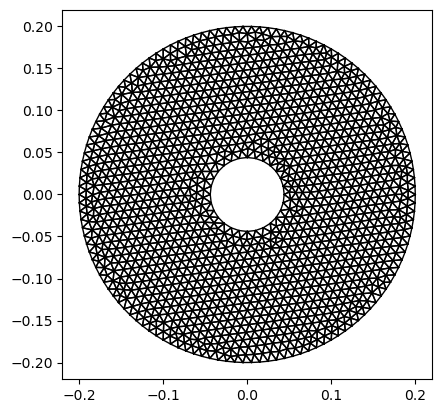

In [3]:
# Import mesh
brake = import_mesh("brake.vtk", C=C)
brake.plot()
plt.axis("on")

d = 0.0018
thickness = d * torch.ones(len(brake.elements))

Nodes located on the outer boundary have been designated as 'Outer_tensor,' while those on the inner boundary have been denoted as 'Inner_tensor.

In [4]:
# Initialize tensors for different regions
outer_tensor = []
inner_tensor = []

# Iterate through nodes
for node_id, node_coords in enumerate (brake.nodes):
    x, y = node_coords

    # Calculate the distance from the center
    distance_to_center = torch.norm(node_coords)

    if distance_to_center > 0.199:
        outer_tensor.append(node_id)
    # Check if the node is on the inner radius
    elif distance_to_center < 0.045:
        inner_tensor.append(node_id)




Tangential Load (Clamping Force) is applied on the inner Boundary where Brake disc is mounted on wheel which imparts the motion on to the brake disc.

The Constrains are applied on the outer boundary mimicking the static Breaking system

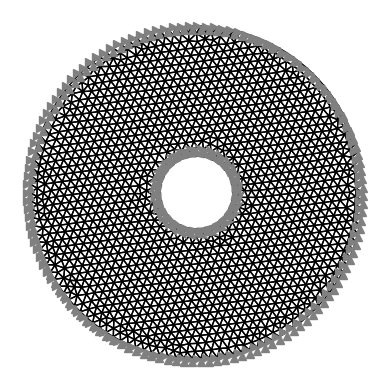

In [7]:

outer_points = brake.nodes[outer_tensor]
inner_points = brake.nodes[inner_tensor]


i = torch.arctan2(inner_points[:,0],inner_points[:,1]) - torch.pi/2.0


brake.forces[inner_tensor,0] = 0.001*torch.sin(i)
brake.forces[inner_tensor,1] = 0.001*torch.cos(i)
brake.constraints[outer_tensor,0] = True
brake.constraints[outer_tensor,1] = True


brake.plot()



The Geometry model of the brake disc is solved with FEM module for the forces and constrained applied on it

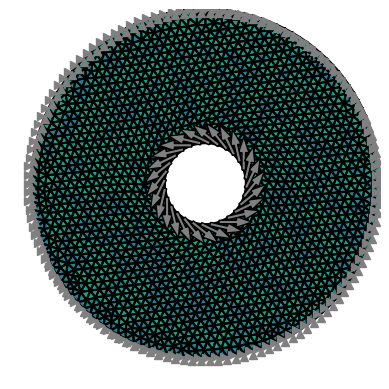

In [8]:
Disc = FEM(brake.nodes, brake.elements, brake.forces, brake.constraints, thickness=thickness, E=E, nu=nu)


u, f = Disc.solve()
Disc.plot(u=u, node_property=f[:, 0])



# Topology Optimisation with optimality criteria

In [9]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [10]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0):
    rho = [rho_0]
    vols = d * fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        H = r - fem.dist
        H[fem.dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        w_k = fem.element_strain_energies(u_k)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

In [11]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.1 * torch.ones(len(brake.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * Disc.areas()
V0 = 0.4 * vols.sum()

Iteration k=0 - Compliance: 0.43695
Iteration k=1 - Compliance: 0.25287
Iteration k=2 - Compliance: 0.14633
Iteration k=3 - Compliance: 0.08468
Iteration k=4 - Compliance: 0.04901
Iteration k=5 - Compliance: 0.02836
Iteration k=6 - Compliance: 0.01660
Iteration k=7 - Compliance: 0.01006
Iteration k=8 - Compliance: 0.00639
Iteration k=9 - Compliance: 0.00373
Iteration k=10 - Compliance: 0.00281
Iteration k=11 - Compliance: 0.00233
Iteration k=12 - Compliance: 0.00201
Iteration k=13 - Compliance: 0.00173
Iteration k=14 - Compliance: 0.00148
Iteration k=15 - Compliance: 0.00126
Iteration k=16 - Compliance: 0.00108
Iteration k=17 - Compliance: 0.00094
Iteration k=18 - Compliance: 0.00085
Iteration k=19 - Compliance: 0.00079
Iteration k=20 - Compliance: 0.00076
Iteration k=21 - Compliance: 0.00074
Iteration k=22 - Compliance: 0.00073
Iteration k=23 - Compliance: 0.00072
Iteration k=24 - Compliance: 0.00071
Iteration k=25 - Compliance: 0.00070
Iteration k=26 - Compliance: 0.00070
Iteration k

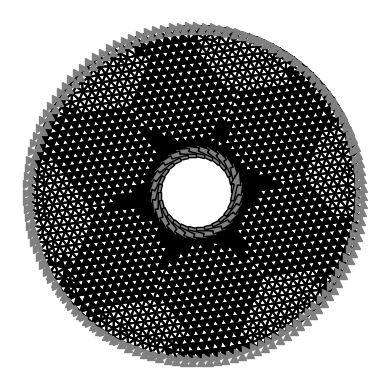

In [13]:
# Optimize and visualize results
d_opt = optimize(Disc, rho_0, rho_min, rho_max, V0, iter=50, p=3.0, r=0.0)
Disc.plot(element_property=d_opt[-1])


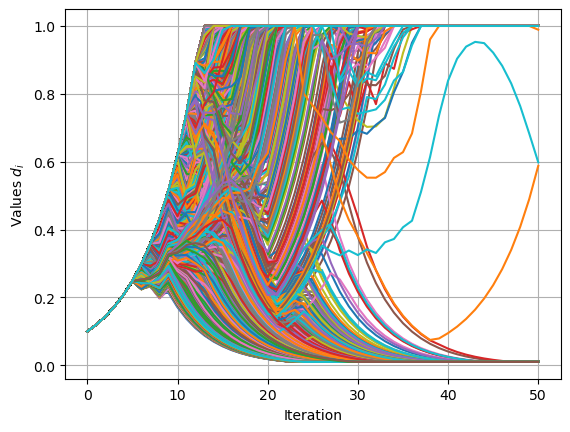

In [14]:

plt.plot(d_opt)
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

Iteration k=0 - Compliance: 0.43695
Iteration k=1 - Compliance: 0.25287
Iteration k=2 - Compliance: 0.14633
Iteration k=3 - Compliance: 0.08468
Iteration k=4 - Compliance: 0.04901
Iteration k=5 - Compliance: 0.02836
Iteration k=6 - Compliance: 0.01659
Iteration k=7 - Compliance: 0.01006
Iteration k=8 - Compliance: 0.00639
Iteration k=9 - Compliance: 0.00375
Iteration k=10 - Compliance: 0.00289
Iteration k=11 - Compliance: 0.00253
Iteration k=12 - Compliance: 0.00241
Iteration k=13 - Compliance: 0.00239
Iteration k=14 - Compliance: 0.00238
Iteration k=15 - Compliance: 0.00236
Iteration k=16 - Compliance: 0.00234
Iteration k=17 - Compliance: 0.00230
Iteration k=18 - Compliance: 0.00221
Iteration k=19 - Compliance: 0.00207
Iteration k=20 - Compliance: 0.00185
Iteration k=21 - Compliance: 0.00159
Iteration k=22 - Compliance: 0.00136
Iteration k=23 - Compliance: 0.00117
Iteration k=24 - Compliance: 0.00105
Iteration k=25 - Compliance: 0.00098
Iteration k=26 - Compliance: 0.00092
Iteration k

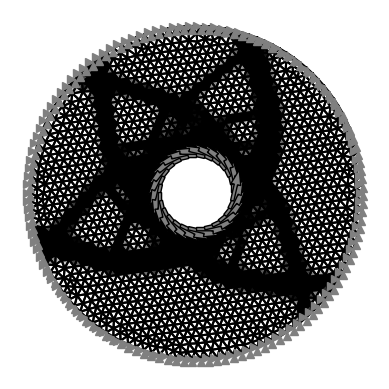

In [15]:
d_opt = optimize(Disc, rho_0, rho_min, rho_max, V0, iter=100, p=3.0, r=0.01)
Disc.plot(element_property=d_opt[-1])

From the above designs, we can interoret that the design we obtained through optimisation as shown below:

<div>
    <center>
        <img src="Interpreted Design.png" width="250"/>
    </center>
</div>


However, if we account for the thermal stresses we can interpret the design as :

<div>
    <center>
        <img src="Thermally Optimised.png" width="250"/>
    </center>
</div>

which is very close to the one available in the market

<div>
    <center>
        <img src="Shimano.jpg" width="250"/>
    </center>
</div>